# Projektni zadatak is Sistema odlučivanja u medicini

Pitanja:

1. Da li biramo 10 obeležja pre ili posle analize (ispitivanje korelacija i IG), sa kojim setom obeležja se nastavlja dalje - da li postoji striktan način odabira?
2. Da li je godište donora validan fičer jer se ispostavlja da on ima baš veliku informacionu dobit + šta da radimo sa survival_time_numeric, nije baš fer fičer haha

In [1]:
# učitavanje biblioteka 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold

# 1. Učitavanje i pretprocesiranje podataka

In [2]:
data = pd.read_csv('03_bone_marrow_dataset.csv')
print("Dimenzije skupa podataka: ", data.shape)

Dimenzije skupa podataka:  (187, 37)


In [3]:
# brišemo razmak na kraju naziva atributa (lakše je za kasniju analizu)
for attribute in data.columns:
    if(attribute[-1] == ' '):
        data.rename(columns = {attribute:attribute[0:-1]}, inplace = True)
attributes = data.columns
data

,Recipientgender,Stemcellsource,Donorage numeric,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6 numeric,CD3dCD34 numeric,CD3dkgx10d8 numeric,Rbodymass numeric,ANCrecovery numeric,PLTrecovery numeric,time_to_aGvHD_III_IV numeric,survival_time numeric,survival_status numeric
0,1,1,22.830137,0,1,0,1,1,1,0,...,1,7.20,1.33876,5.38,35,19,51,32,999,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,7.94,19.01323,0.42,23.4,23,20,1000000,435,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,?,4.25,29.481647,0.14,50,23,29,19,53,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,51.85,3.972255,13.05,9,14,14,1000000,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,...,1,11.08,2.52275,4.39,44,15,22,16,385,1
183,0,1,22.895890,0,0,0,1,0,1,1,...,1,4.64,1.038858,4.47,44.5,12,30,1000000,634,1
184,0,1,27.347945,0,1,0,1,-1,1,1,...,1,7.73,1.635559,4.73,33,16,16,1000000,1895,0
185,1,1,27.780822,0,1,0,1,0,1,1,...,0,15.41,8.07777,1.91,24,13,14,54,382,1


Podaci koji se nalaze u bazi:       

1. Recipientgender - Pol pacijenta: 0 ili 1    
2. Stemcellsource - Izvor ćelija (periferna krv, koštana srž): 0 ili 1
3. Donorage numeric - Starost davaoca u vreme afereze hematopoetskih matičnih ćelija: float num 18.646575 - 55.553425
4. Donorage35 - Da li je starost donora manja od 35 godina: 0 ili 1
5. IIIV - razvoj bolesti transplantata 3. ili 4. stepena: 0 ili 1 
6. Gendermatch - kompatibilnost donora i primaoca prema polu: 0 ili 1
7. DonorABO - krvna grupa donora: -1, 0, 1, 2
8. <font color=red>RecipientABO - krvna grupa pacijenta: -1, 0, 1, 2</font>
9. <font color=red>RecipientRh - da li pacijent ima Rh raktor: 0 ili 1</font>
10. <font color=red>ABOmatch - kompatibilnost pacijenta i donora po krvnoj grupi: 0 ili 1</font>
11. <font color=red>CMVstatus - kompatibilnost pacijenta i donora prema citomegalo virusu koji se može razviti (što je veća kompatibilnost to je lošije po pacijenta): num 0, 1, 2, 3 i ? </font>
12. <font color=red>DonorCMV - postojanje citomegalo virusne infekcije kod donora pre transplantacije: 0 ili 1 </font>
13. <font color=red>RecipientCMV - postojanje citomegalo virusne infekcije kod pacijenta pre transplantacije: 0 ili 1 </font>
14. Disease - vrsta bolesti: ALL, AML, chronic, nonmalignant, lymphoma
15. Riskgroup - rizična grupa: 0 ili 1
16. Txpostrelapse - da li je rađena druga transplantacija nakon što je prva prošla loše: 0 ili 1
17. Diseasegroup - da li je oboljenje maligno ili nije: 0 ili 1
18. HLAmatch - grupe antigena donora i primaoca: 0, 1, 2, 3
19. HLAmismatch - da li su se antigeni poklopili: 0 ili 1
20. <font color=red>Antigen - u koliko antigena postoji razlika između donora i pacijenta: -1, 0, 1, 2 i ?</font>
21. <font color=red>Alel - u koliko allela postoji razlika između donora i pacijenta: -1, 0, 1, 2, 3, ?</font>
22. HLAgrI - razlika između donora i primaoca u parametrima kao što su antigen, alel, HLA, itd: 0, 1, 2, 3, 4, 5, 6, 7
23. Recipientage numeric - starost pacijenta u trenutku transplantacije: 0.6 - 20.2
24. Recipientage10 - da li je starost pacijenta manja od 10 godina: 0 ili 1 
25. Recipientageint - godište pacijenta diskretizovano po intervalima: 0, 1, 2
26. Relapse - povratak bolesti: 0 ili 1
27. aGvHDIIIIV - da li se razvila neka bolest 3. i 4. stepena: 0 ili 1
28. <font color=red>extcGvHD - da li se razvila neka bolest 3. i 4. stepena: 0, 1 i ?</font>
29. CD34kgx10d6 numeric - doza neke vrste ćelija skalirana po težini čoveka: float 0.79 - 57.78 
30. <font color=red>CD3dCD34 numeric - doza druge vrste ćelija skalirana po dozi druge vrste: float 0 - 99.56097 i ?</font>
31. <font color=red>CD3dkgx10d8 numeric - doza neke vrste ćelija skalirana po težini čoveka: float 0 - 20.02 i ?</font>
32. <font color=red>Rbodymass numeric - bodymass indeks pacijenta: float 0 - 103.4 i ?</font>
33. ANCrecovery numeric - oporavak neutrofila definisan kao njihov broj (>0.5 je da) : float 9 - 26.0 i 1000000.0
34. PLTrecovery numeric - oporavak trombocita definisam njihov broj (>50000 da): float 9 - 285 i 1000000.0 
35. time_to_aGvHD_III_IV numeric - vreme u danima proteklo do razvoja akutne bolesti transplantata 3. ili 4. stepena: 10 - 100 i 1000000
36. survival_time numeric - vreme posmatranja (u slučaju živog pacijenta) ili vreme do smrti: 6 - 3364
37. survival_status numeric - da li je osoba živa ili mrtva: 0 ili 1


In [4]:
print(set(data.dtypes))
data.dtypes[data.dtypes == 'O']

{dtype('int64'), dtype('float64'), dtype('O')}


RecipientABO           object
RecipientRh            object
ABOmatch               object
CMVstatus              object
DonorCMV               object
RecipientCMV           object
Disease                object
Antigen                object
Alel                   object
extcGvHD               object
CD3dCD34 numeric       object
CD3dkgx10d8 numeric    object
Rbodymass numeric      object
dtype: object

U tabeli se nalaze vrednosti koje nisu samo numeričke ( int / float ).     
Potrebno je proveriti da li neke kolone koje imaju više tipova podataka (njihov tip je object) sadrže i nepostojeće vrednosti (obeležene su sa "?" npr). Kolone koje sadrže neprihvaćene vrednosti su u podacima obeležene crvenom bojom.

#### Sređivanje podataka

Ni u jednoj klasi obeležja ne nedostaje veliki broj vrednosti. One nevalidne se u slučaju kategoričke vrednosti menjaju modom, a u slučaju kontinualne medijanom.

In [5]:
# return the most frequent character in the column
def find_mod(col):
    return Counter(data[col][data[col]!='?']).most_common(1)[0][0]

In [6]:
cols_mod = ["RecipientABO", "RecipientRh", "ABOmatch", "CMVstatus", "DonorCMV", "RecipientCMV", "Antigen", "Alel", "extcGvHD"]
data[cols_mod] = data[cols_mod].replace('?', pd.DataFrame.mode(data[cols_mod]).iloc[0])
data[cols_mod] = data[cols_mod].astype('int64')

cols_median = ["CD3dCD34 numeric", "CD3dkgx10d8 numeric", "Rbodymass numeric"]
data[cols_median] = data[cols_median].replace('?', np.nan)
data[cols_median] = data[cols_median].fillna(data[cols_median].median())
data[cols_median] = data[cols_median].astype('float64')


Svi podaci koji su brojevi a predstavljeni su kao string u bazi se konvertuju u odgovarajući tip podataka

In [7]:
data['RecipientABO'] = data['RecipientABO'].astype('int64')
data['RecipientRh'] = data['RecipientRh'].astype('int64')
data['ABOmatch'] = data['ABOmatch'].astype('int64')
data['CMVstatus'] = data['CMVstatus'].astype('int64')
data['DonorCMV'] = data['DonorCMV'].astype('int64')
data['RecipientCMV'] = data['RecipientCMV'].astype('int64')
data['Antigen'] = data['Antigen'].astype('int64')
data['Alel'] = data['Alel'].astype('int64')
data['extcGvHD'] = data['extcGvHD'].astype('int64')

data['CD3dCD34 numeric'] = data['CD3dCD34 numeric'].astype('float64')
data['CD3dkgx10d8 numeric'] = data['CD3dkgx10d8 numeric'].astype('float64')
data['Rbodymass numeric'] = data['Rbodymass numeric'].astype('float64')


Kodovanje kategoričkog atributa disease 

In [8]:
print(set(data['Disease']))
data = data.replace({'Disease' : {'chronic' : 0, 'lymphoma' : 1, 'AML' : 2, 'nonmalignant' : 3, 'ALL': 4}})

{'AML', 'chronic', 'nonmalignant', 'lymphoma', 'ALL'}


In [9]:
# ovaj atribut potpuno nema smisla jer je direktno korelisan sa izlazom (ako je neko praćen samo 100 dana, skoro sigurno je preminuo)
data.drop(['survival_time numeric'], axis = 1, inplace = True)

# 2. Izdvajanje obeležja

## 2.1. Selekcija obeležja

In [10]:
# ovde se bira samo 10 obeležja - treba proveriti sa Marijom Novičić da li se biraju proizvoljna ili neka istaknuta
data_corr = data[data.columns[0 : 10]]
data_corr = data_corr.join(data['survival_status numeric'].copy())
data_corr


,Recipientgender,Stemcellsource,Donorage numeric,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,survival_status numeric
0,1,1,22.830137,0,1,0,1,1,1,0,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,1
3,0,0,39.684932,1,1,0,1,2,1,1,1
4,0,1,33.358904,0,0,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,1
183,0,1,22.895890,0,0,0,1,0,1,1,1
184,0,1,27.347945,0,1,0,1,-1,1,1,0
185,1,1,27.780822,0,1,0,1,0,1,1,1


Pirsonov koeficijent korelacije je prikladan za procenu linearnih zavisnosti između kontinualnih tipova obeležja, dok je Spirmanov koeficijent korelacije pogodan za procenu monotonih odnosa (koji nisu nužno linearni) između obeležja, odnosno promenljivih koje mogu biti numeričke ili kategoričke. S obzirom da pri radu sa našom bazom baratamo i sa kategoričkim obeležjima, odlučujemo se za Spirmanov koeficijent korelacije.

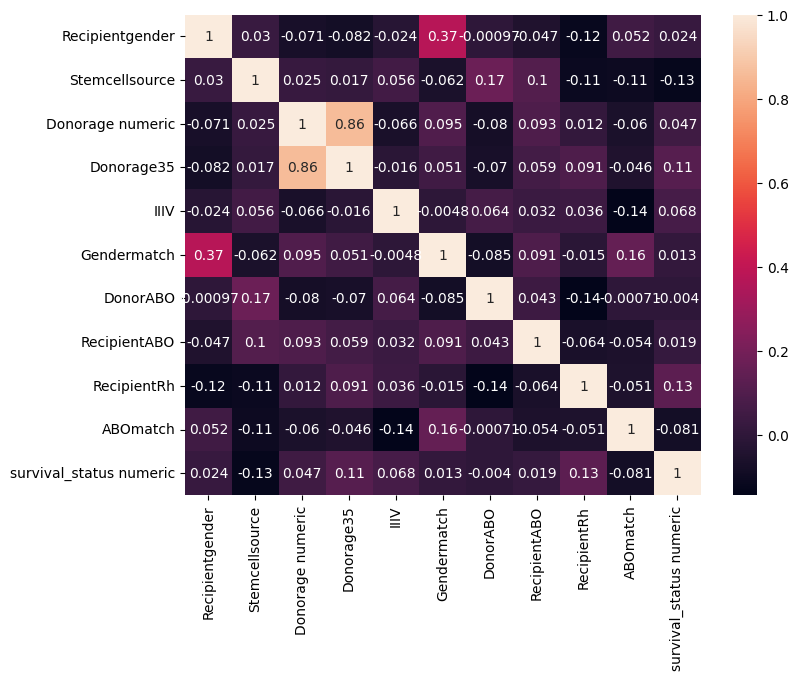

In [11]:
spearman_R = data_corr.corr(method='spearman')
plt.figure(figsize=(6.4 * 1.3, 4.8 * 1.3))
sns.heatmap(spearman_R, annot=True)
plt.show()

In [12]:
def calculateInfoD(col):
    unique = Counter(col)

    total = len(col)
    frequencies = np.array(list(unique.values()), dtype=np.int64)

    p_all = frequencies / total
    infoD = -np.sum(np.multiply(p_all, np.log2(p_all)))
    return infoD

In [13]:
def analysisIG(data_corr, infoD, klasa):
    IG = dict()

    for feature_idx in range(data_corr.shape[1]-1):
        # ovde je Marija skalirala vrednosti kolona nekako ali ne razumem bas sta je tacno tu uradila

        col_values = data_corr.iloc[:, feature_idx]
        
        f = np.unique(col_values)
        infoDA = 0
        for i in f:
            temp = klasa[col_values == i]

            infoDi = calculateInfoD(temp)
            Di = sum(col_values == i)
            D = len(col_values)

            infoDA += Di * infoDi / D
        
        IG[feature_idx] = infoD - infoDA

        print('IG' + str(feature_idx) + ' = ' 'IG(' + data_corr.columns[feature_idx] + ') = ' + str(infoD - infoDA))    
        print('------')
        
    IGsorted = dict(sorted(IG.items(), key=lambda item: item[1]))
    print('Sortirano IG = \n', IGsorted)

    return IGsorted

In [14]:
klasa = data_corr.iloc[:,-1]
infoD = calculateInfoD(klasa)

IGsorted = analysisIG(data_corr, infoD, klasa)

IG0 = IG(Recipientgender) = 0.00041248804242211
------
IG1 = IG(Stemcellsource) = 0.011480699921597504
------
IG2 = IG(Donorage numeric) = 0.9940302114769565
------
IG3 = IG(Donorage35) = 0.00937784655669216
------
IG4 = IG(IIIV) = 0.0033176265497799617
------
IG5 = IG(Gendermatch) = 0.00012104129368917249
------
IG6 = IG(DonorABO) = 0.01199330323187775
------
IG7 = IG(RecipientABO) = 0.0026128131980167613
------
IG8 = IG(RecipientRh) = 0.01269866843063927
------
IG9 = IG(ABOmatch) = 0.004676509383316874
------
Sortirano IG = 
 {5: 0.00012104129368917249, 0: 0.00041248804242211, 7: 0.0026128131980167613, 4: 0.0033176265497799617, 9: 0.004676509383316874, 3: 0.00937784655669216, 1: 0.011480699921597504, 6: 0.01199330323187775, 8: 0.01269866843063927, 2: 0.9940302114769565}


Ono što možemo zaključiti na osnovu vrednosti IG za 10 odabranih obeležja jeste da uzrast donora nosi najveću informaciju, dok preklapanje polova predstavlja najmanje značajan podatak za određivanje klase.

### Analiza nad svim karakteristikama

In [15]:
data_corr = data.drop('survival_status numeric', axis = 1)
data_corr = data_corr.join(data['survival_status numeric'].copy())

In [16]:
klasa = data_corr.iloc[:,-1]
infoD = calculateInfoD(klasa)

IGsorted = analysisIG(data_corr, infoD, klasa)
IGsorted = dict(sorted(IGsorted.items(), key=lambda item: item[1], reverse=True))

IG0 = IG(Recipientgender) = 0.00041248804242211
------
IG1 = IG(Stemcellsource) = 0.011480699921597504
------
IG2 = IG(Donorage numeric) = 0.9940302114769565
------
IG3 = IG(Donorage35) = 0.00937784655669216
------
IG4 = IG(IIIV) = 0.0033176265497799617
------
IG5 = IG(Gendermatch) = 0.00012104129368917249
------
IG6 = IG(DonorABO) = 0.01199330323187775
------
IG7 = IG(RecipientABO) = 0.0026128131980167613
------
IG8 = IG(RecipientRh) = 0.01269866843063927
------
IG9 = IG(ABOmatch) = 0.004676509383316874
------
IG10 = IG(CMVstatus) = 0.00805829638734823
------
IG11 = IG(DonorCMV) = 0.002620124005733193
------
IG12 = IG(RecipientCMV) = 0.0035498481808541316
------
IG13 = IG(Disease) = 0.058865886311242344
------
IG14 = IG(Riskgroup) = 0.015736015242410084
------
IG15 = IG(Txpostrelapse) = 0.009675425877970212
------
IG16 = IG(Diseasegroup) = 0.0038445765348088523
------
IG17 = IG(HLAmatch) = 0.002780467756482663
------
IG18 = IG(HLAmismatch) = 4.8563374402621484e-05
------
IG19 = IG(Ant

In [17]:
# top 10 karakterisitka
list(IGsorted.keys())[0:10]

[2, 29, 28, 30, 31, 22, 33, 34, 32, 25]

In [18]:
data_corr_10 = data_corr[data_corr.columns[list(IGsorted.keys())[0:10]]]

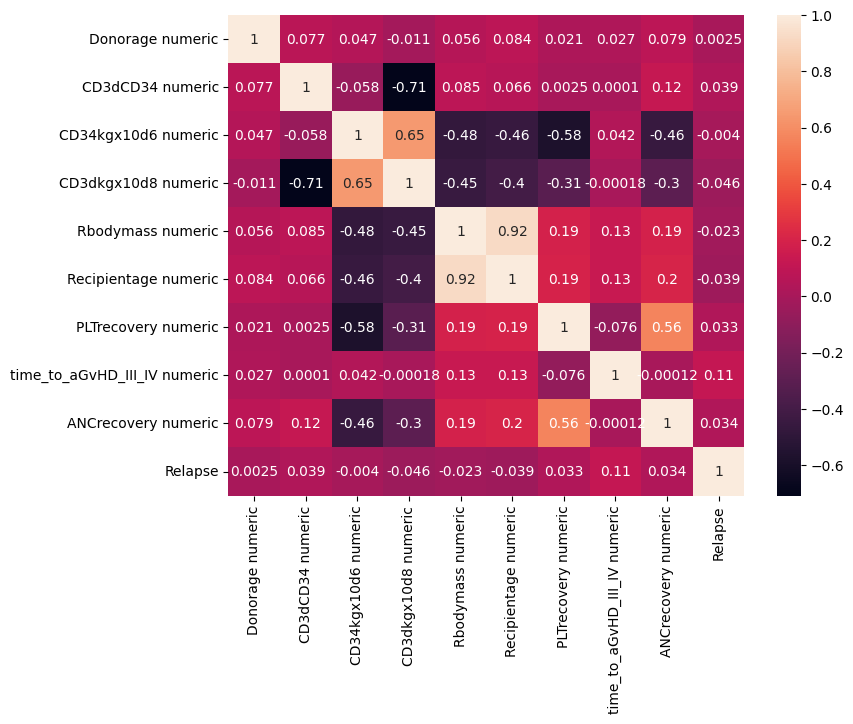

In [19]:
spearman_R = data_corr_10 .corr(method='spearman')
plt.figure(figsize=(6.4 * 1.3, 4.8 * 1.3))
sns.heatmap(spearman_R, annot=True)
plt.show()

Vidi se da je korelisanost fičera CD3dkgx10d8 i CD3dCD34, PLTrecovery i CD34dkgx10d6, CD34dkgx10d6 i CD3dkgx10d8, kao i ANCrecovery i PLTrecovery veoma velika, tako da je potrebno izbaciti neke od njih.

In [20]:
data_corr_10 = data_corr[data_corr.columns[list(IGsorted.keys())[0:13]]]
data_corr_10.drop('CD3dkgx10d8 numeric', axis = 1, inplace = True)
data_corr_10.drop('PLTrecovery numeric', axis = 1, inplace = True)

C:\Users\jn200100d\AppData\Local\Temp\ipykernel_23344\4105094829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr_10.drop('CD3dkgx10d8 numeric', axis = 1, inplace = True)
C:\Users\jn200100d\AppData\Local\Temp\ipykernel_23344\4105094829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr_10.drop('PLTrecovery numeric', axis = 1, inplace = True)


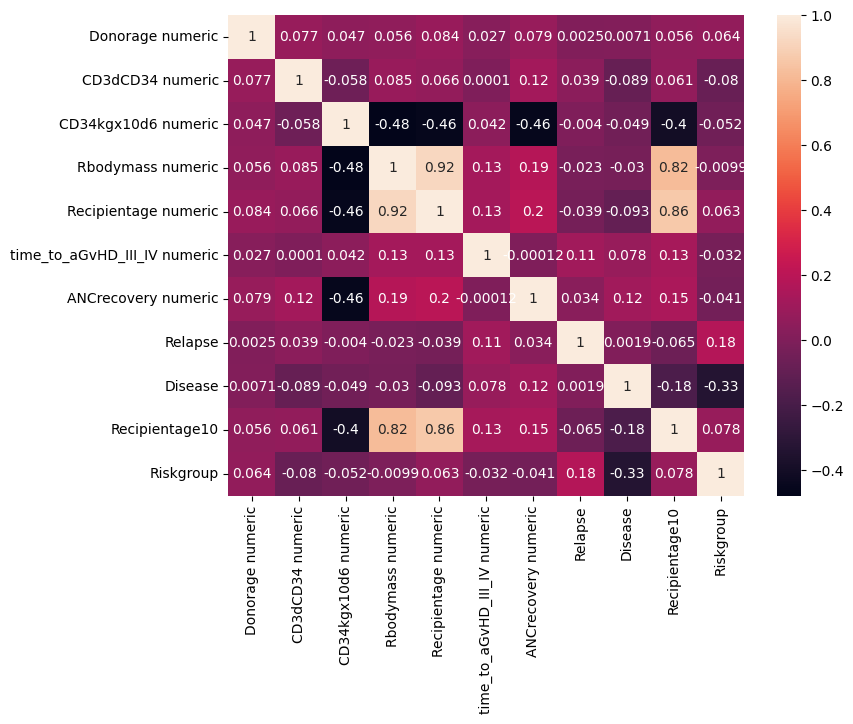

In [21]:
spearman_R = data_corr_10.corr(method='spearman')
plt.figure(figsize=(6.4 * 1.3, 4.8 * 1.3))
sns.heatmap(spearman_R, annot=True)
plt.show()

Ovakva korelacija i informaciona dobit je korektna za 10 najboljih karakteristika koje bi se kasnije razmatrale. 
   
Analiza PCA I LDA samo nad ovim setom:   
1. LDA daje slične rezultate - mozda za nijansu lošije
2. PCA daje znatno bolje rezultate, mnogo nepotrebnih fičera ga previše zatrpa

## 2.2. Ekstrakcija obeležja

In [22]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [23]:
X = data.drop('survival_status numeric', axis=1)
D = data['survival_status numeric']

In [24]:
def normalize(X):
    
    # za analizu sa 10 obeležja
    # X_norm = data_corr_10 
    X_norm = X 
    X_mean = np.mean(X, axis = 0)
    X_max = np.max(X, axis = 0)
    X_std = np.std(X, axis = 0)
    #X_norm = (X - X_mean) / X_max

    cols = ['Donorage numeric', 'Recipientage numeric', 'CD34kgx10d6 numeric', 'CD3dCD34 numeric', 'CD3dkgx10d8 numeric', 'Rbodymass numeric', 'ANCrecovery numeric', 'PLTrecovery numeric', 'time_to_aGvHD_III_IV numeric']
    X_norm[cols] = (X[cols] - X_mean[cols]) / X_std[cols]

    return X_norm

Nema smisla koristiti LDA metodu na sužavanje skupa karakteristika na 2 ili 3 dimenzije jer je maksimalan broj karakteristika koji se može dobiti = min(broj_karakteristika, broj_klasa - 1) = min(36, 2 - 1) = min(36, 1) = 1 => jednodimenzionalna projekcija.    


##### Redukcija PCA na dve dimenzije

In [25]:
pca = PCA(n_components = 2)
X_norm = normalize(X)
data_pca_fcn = pd.DataFrame(pca.fit_transform(X_norm))

data_pca_fcn = pd.concat([data_pca_fcn,D], axis = 1)
data_pca_fcn.columns = ['PCA1', 'PCA2', 'Class']

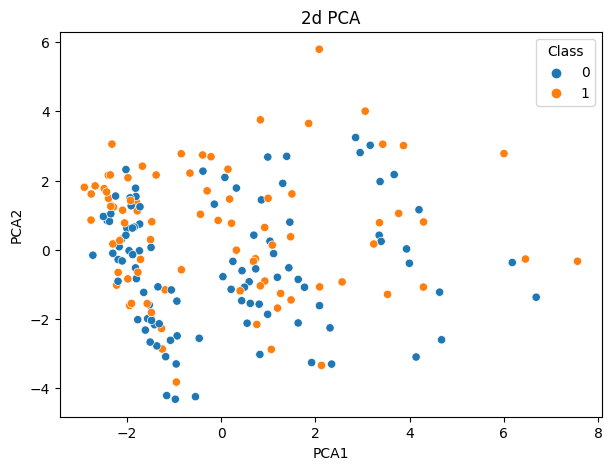

In [26]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data = data_pca_fcn, x = 'PCA1', y = 'PCA2', hue = 'Class')
plt.title('2d PCA')
plt.show()

Uz drugačiju normalizaciju podataka, dobijaju se malo drugačiji rezultati, ali ništa što bi dalo uočljiviju separabilnost klasa.

##### Redukcija LDA na jednu dimenziju

In [27]:
lda = LDA(solver = 'eigen', n_components = 1)
data_lda_fcd = pd.DataFrame(lda.fit_transform(X_norm, D))

data_lda_fcd = pd.concat((data_lda_fcd, D), axis = 1)
data_lda_fcd.columns = ['LDA1', 'Class']

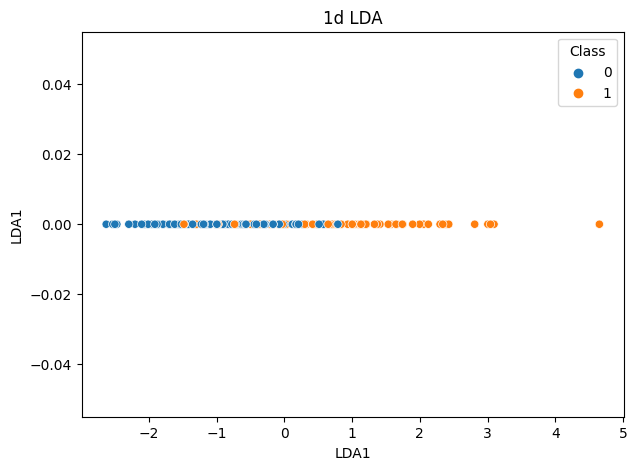

In [28]:
plt.figure(figsize = (7, 5))
sns.scatterplot(x = data_lda_fcd['LDA1'], y = [0]*data_lda_fcd['LDA1'], hue = data_lda_fcd['Class'])
plt.title('1d LDA')
plt.show()

##### Komentar

Pošto je ova baza podataka podeljena na dve klase - preživeli i mrtvi, potrebno je uporediti performanse 1d LDA i 2d PCA metode.     
Sa grafika se može zaključiti da mnogo bolje rezultate daje 1d LDA metoda. Ona se koristi kada nam je potrebno da maksimizujemo separabilnost klasa, oslanjajući se na već postojeće labele; dok je PCA nenadgledana metoda koja se bazira na pronalasku maksimalne varijacije svih podataka u bazi. Ona potencijalno može biti pogodnija ukoliko imamo manji broj odbiraka po klasi, što trenutno nije slučaj.     
Grafici distribucije odbiraka po klasama su prikazani u prethodnim koracima u zavisnosti od korišćene metode.

Analiza PCA i LDA nad setom od 10 najboljih karakterisitka (postupak biranja je opisan u prethodnom koraku) dovodi do vidnog (ali ne i dovoljno dobrog) poboljšanja PCA klasifikatora, dok LDA daje relativno slične rezultate.

# 3. Projektovanje klasifikatora

## 3.1. Parametarska klasifikacija

In [29]:
x = data_lda_fcd['LDA1']
y = np.array(data_lda_fcd['Class'])

x_c0 = np.array(x[y == 0])
n_0 = np.sum(y == 0)
x_c0 = x_c0.reshape(1, n_0)

x_c1 = np.array(x[y == 1])
n_1 = np.sum(y == 1)
x_c1 = x_c1.reshape(1, n_1)

print(np.ones((1, n_0)).shape)
Z1 = np.matrix(np.append(-x_c0, -np.ones((1, n_0)), axis=0))
print(Z1.shape)
Z2 = np.matrix(np.append(x_c1, np.ones((1, n_1)), axis=0))
U = np.append(Z1, Z2, axis=1).T
print(U.shape)

U_train, U_test, y_train, y_test = train_test_split(U, y, train_size=2/3, random_state=42, stratify=y)

G = np.matrix(np.ones(y_train.shape[0]))
W = (U_train.T * U_train) ** (-1) * U_train.T * G.T
W = np.asarray(W).T[0]

print(np.array(W))

(1, 102)
(2, 102)
(187, 2)
[ 0.51480019 -0.01054337]


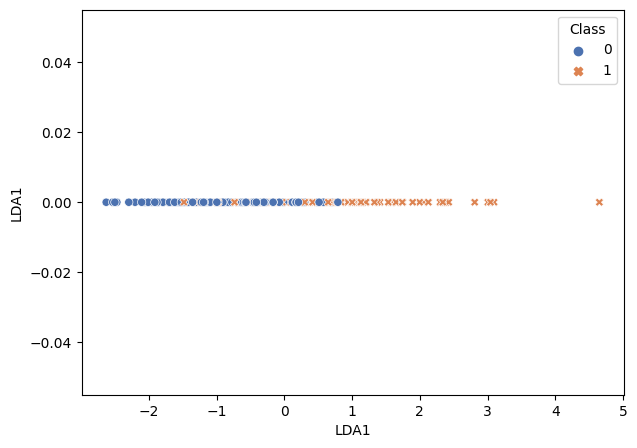

In [30]:
plt.figure(figsize = (7, 5))
sns.scatterplot(x = data_lda_fcd['LDA1'], y = [0]*data_lda_fcd['LDA1'], hue = data_lda_fcd['Class'], style=data_lda_fcd['Class'], palette="deep")
plt.show()

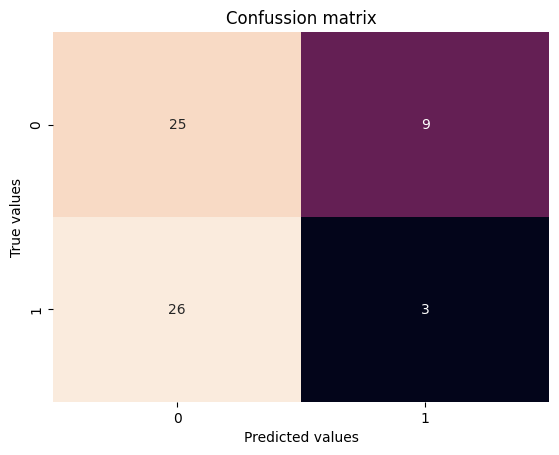

In [31]:
y_pred = W * U_test.T
y_pred = np.asarray(y_pred.T, dtype=int)
y_test = y_test.reshape(y_test.shape[0], 1)

cm = confusion_matrix(y_test, np.asarray(y_pred, dtype=int))
class_labels = ['Class 0', 'Class 1']

plt.figure()
sns.heatmap(cm, annot=True, fmt='g', cbar=False)
plt.title("Confussion matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

## 3.2 Neparametarska klasifikacija

Podaci koje analiziramo sastoje se od 187 ispitanika sa 37 karakterističnih obeležja.     
Za takvu veličinu baze, KNN bi potencijalno bio bolji izbor jer se stabla odlučivanja mogu preobučiti ili postati previše kompleksna. Međutim, dimenzionalnost baze (37 karakteristika) potencijalno može biti problem za KNN klasifikator.
Klase su prilično dobro izbalansirane, sa 85 preživelih osoba i 102 nesrećna slučaja. Tako da izbalansiranost takođe neće predstavljati problem i oba klasifikatora dolaze u obzir.

Iz prethodne diskusije zaključuje se da su oba klasifikatora slične pogodnosti za ovu bazu i problematiku, te je svakako najbolji izbor uporediti njihove performanse.

Kao metrika za dobijanje tačnosti što nezavisnije od raspodele podataka koristiće se krosvalidacija (leave-one-out).

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [33]:
data['survival_status numeric'].value_counts()

0    102
1     85
Name: survival_status numeric, dtype: int64

Priprema podataka za klasifikaciju (podela na skupove za treniranje i testiranje)

In [34]:
def prepare_data(data, person):
    
    # Uzimanje jednog pacijenta za treniranje
    X_test = data.iloc[[person]].drop('survival_status numeric', axis = 1).reset_index(drop=True)
    y_test = list(data.iloc[[person]]['survival_status numeric'])
    
    # Mešanje podataka pri kome se indeksi ne gube 
    data_shuff = data.sample(frac = 1)
     
    # Brisanje istog pacijenta i preuređivanje indeksa
    X_train = data_shuff.drop(person).drop('survival_status numeric', axis = 1).reset_index(drop=True)
    y_train = list(data_shuff.drop(person)['survival_status numeric'])
    
    # Povratne vrednosti podataka za treniranje i testiranje, kao i njihovih odgovarajućih labela
    return X_train, X_test, y_train, y_test

In [35]:
num_of_participants = len(data)

Uopštena funkcija za klasifikator u kombinaciji sa podešavanjem optimalnog parametra kao i krosvalidacije

### KNN

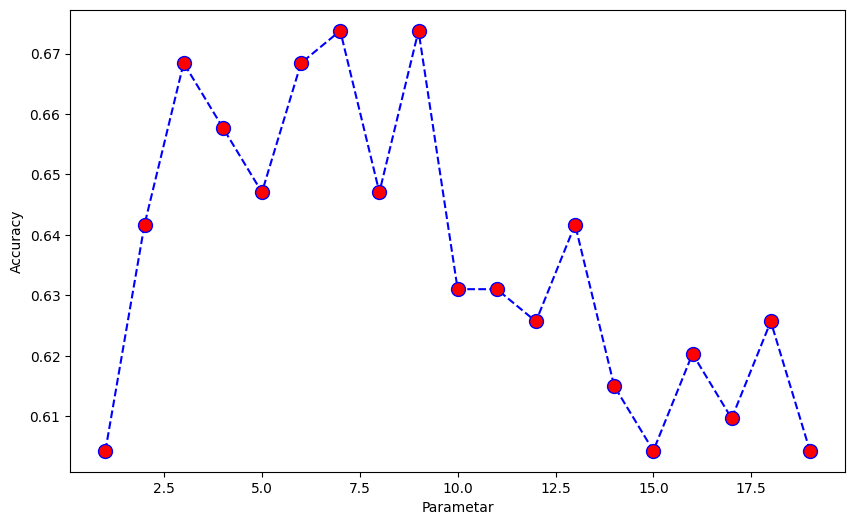

Maksimalna tacnost:  0.6737967914438503 , za vrednost parametra:  7


In [65]:
# Lista koja će sadržati tačnosti za različite vrednosti parametra
acc_diff_param = []

# Iteracija za različite vrednosti parametra
for param in range(1, 20, 1):

    # Lista koja će sadržati tačnosti za različita izostavljanja pacijenta
    accuracy = []

    # Iteracija za različita izostavljanja pacijenta
    kf = KFold(n_splits=187, shuffle=True)
    
    for train_idx, val_idx in kf.split(data):
    
        # Priprema podataka za treniranje i testiranje
        x_dt = data.drop('survival_status numeric',axis=1).to_numpy()
        y_dt = data['survival_status numeric'].to_numpy()
        X_train, X_test, y_train, y_test = x_dt[train_idx], x_dt[val_idx], y_dt[train_idx], y_dt[val_idx]

        # Treniranje i testiranje određenog klasifikatora
        classif = KNeighborsClassifier(n_neighbors=param)
        classif.fit(X_train, y_train)

        y_pred = classif.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))

    acc_diff_param.append(np.mean(accuracy))

# Plotovanje zavisnosti tačnosti za različite vrednosti parametra
figure = plt.figure(figsize=(10, 6))
plt.plot(range(1, 20, 1), acc_diff_param, color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
plt.xlabel('Parametar')
plt.ylabel('Accuracy')
plt.show()

# Ispis maksimalne tačnosti i vrednosti parametra za koju je ona postignuta
vr = acc_diff_param.index(max(acc_diff_param)) + 1
print('Maksimalna tacnost: ', max(acc_diff_param), ', za vrednost parametra: ', vr)

#### KNN sa N najboljih karakteristika određenih analizom informacione dobiti

In [37]:
num_top_chars = 15
list(IGsorted.keys())[0:num_top_chars]
data_smaller = data_corr[data_corr.columns[list(IGsorted.keys())[0:num_top_chars]]]
data_smaller = data_smaller.join(data['survival_status numeric'].copy())

Klasifikacija sa smanjenim broja obeležja ne dovodi do poboljšanja rezultata (ni IG, kao ni PCA), a osim toga i normalizacija dovodi do neznatnog smanjenja tačnosti.

### DT

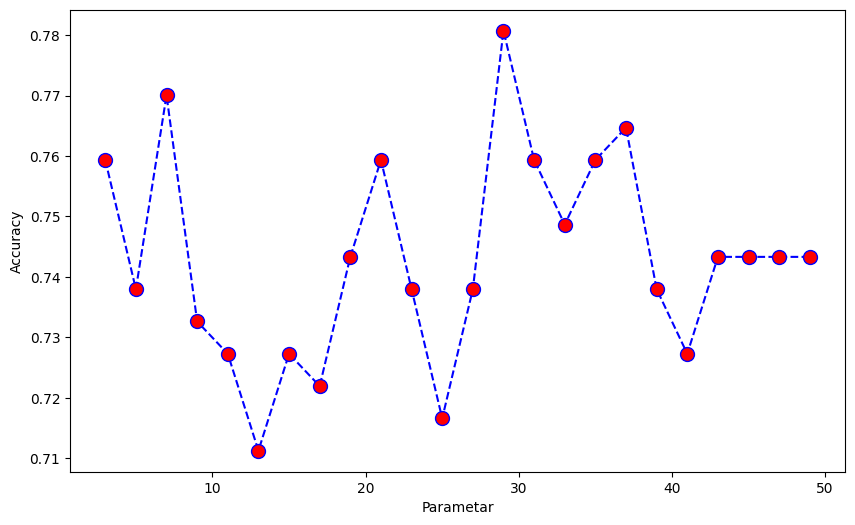

Maksimalna tacnost:  0.7807486631016043 , za vrednost parametra:  29


In [64]:
# Lista koja će sadržati tačnosti za različite vrednosti parametra
acc_diff_param = []

# Iteracija za različite vrednosti parametra
for param in range(3, 50, 2):

    # Lista koja će sadržati tačnosti za različita izostavljanja pacijenta
    accuracy = []

    # Iteracija za različita izostavljanja pacijenta
    kf = KFold(n_splits=187, shuffle=True)
    
    for train_idx, val_idx in kf.split(data):
    
        # Priprema podataka za treniranje i testiranje
        x_dt = data.drop('survival_status numeric',axis=1).to_numpy()
        y_dt = data['survival_status numeric'].to_numpy()
        X_train, X_test, y_train, y_test = x_dt[train_idx], x_dt[val_idx], y_dt[train_idx], y_dt[val_idx]

        # Treniranje i testiranje određenog klasifikatora
        classif = DecisionTreeClassifier(max_depth=param)
        classif.fit(X_train, y_train)

        y_pred = classif.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))

    acc_diff_param.append(np.mean(accuracy))

# Plotovanje zavisnosti tačnosti za različite vrednosti parametra
figure = plt.figure(figsize=(10, 6))
plt.plot(range(3, 50, 2), acc_diff_param, color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
plt.xlabel('Parametar')
plt.ylabel('Accuracy')
plt.show()

# Ispis maksimalne tačnosti i vrednosti parametra za koju je ona postignuta
vr = acc_diff_param.index(max(acc_diff_param)) * 2 + 3
print('Maksimalna tacnost: ', max(acc_diff_param), ', za vrednost parametra: ', vr)

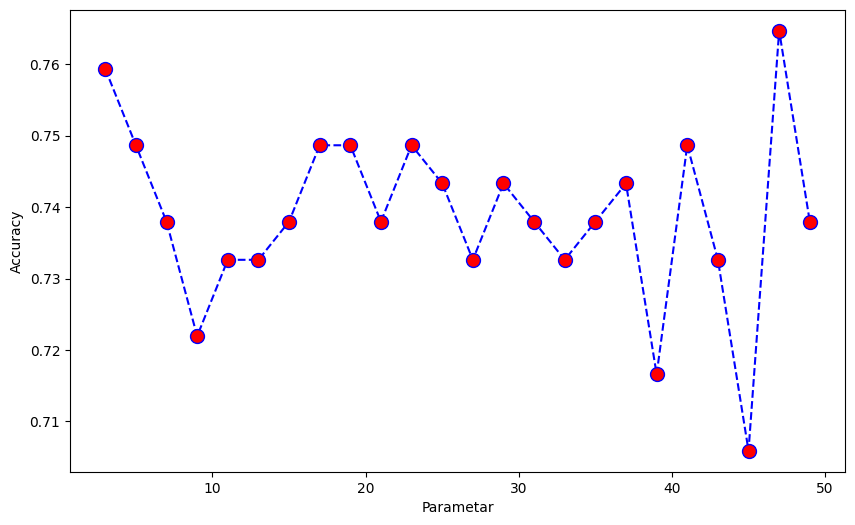

Maksimalna tacnost:  0.7647058823529411 , za vrednost parametra:  47


In [63]:
# Lista koja će sadržati tačnosti za različite vrednosti parametra
acc_diff_param = []

# Iteracija za različite vrednosti parametra
for param in range(3, 50, 2):

    # Lista koja će sadržati tačnosti za različita izostavljanja pacijenta
    accuracy = []

    # Iteracija za različita izostavljanja pacijenta
    for i in range(0, num_of_participants):
    
        # Priprema podataka za treniranje i testiranje
        X_train, X_test, y_train, y_test = prepare_data(data, i)

        # Treniranje i testiranje određenog klasifikatora
        classif = DecisionTreeClassifier(max_depth=param)
        classif.fit(X_train, y_train)

        y_pred = classif.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))

    acc_diff_param.append(np.mean(accuracy))

# Plotovanje zavisnosti tačnosti za različite vrednosti parametra
figure = plt.figure(figsize=(10, 6))
plt.plot(range(3, 50, 2), acc_diff_param, color='blue', linestyle='dashed', marker='o',
            markerfacecolor='red', markersize=10)
plt.xlabel('Parametar')
plt.ylabel('Accuracy')
plt.show()

# Ispis maksimalne tačnosti i vrednosti parametra za koju je ona postignuta
vr = acc_diff_param.index(max(acc_diff_param)) * 2 + 3
print('Maksimalna tacnost: ', max(acc_diff_param), ', za vrednost parametra: ', vr)

Iz priloženih kodova i analiza može se videti da DT daje bolje rezultate od KNNa na celom skupu karakteristika, kao i na suženom skupu (što bi trebalo da popravi tačnost KNN klasifikatora, ali se to ne dešava).   
Sa 15 najbitnijih karakteristika tačnost ostaje potpuno ista kao i sa celim setom (za KNN), dok sa 10 karakteristika već vidimo određeni pad.    
Iako naizgled nije bilo očigledno koji klasifikator bi mogao da radi bolje, a uzimajući u obzir i problematiku klasifikacije, nije začuđujuće što stabla odlučivanja daju bolji rezultat.

#### Za ovakav pristup problemu nije najpraktičniji za prikazivanje matrice konfuzije, ali je to prikazano na primeru drugačije podele podataka i testiranja.

Accuracy:  0.6507936507936508


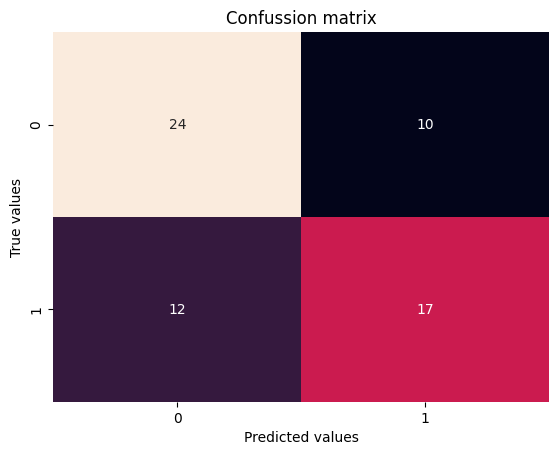

In [40]:
# Podela podataka
X_train, X_test, y_train, y_test = train_test_split(data.drop('survival_status numeric', axis = 1), data['survival_status numeric'], train_size=2/3, random_state=42, stratify=data['survival_status numeric'])
    
# Treniranje i testiranje stabla odlučivanja
classif = DecisionTreeClassifier(max_depth=4)
classif.fit(X_train, y_train)

y_pred = classif.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: ', accuracy)

# Prikaz maatrice konfuzije
cm = confusion_matrix(y_test, y_pred)
class_labels = ['Class 0', 'Class 1']
plt.figure()
sns.heatmap(cm, annot=True, fmt='g', cbar=False)
plt.title("Confussion matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

## 3.3. Neuralna mreža

In [41]:
import tensorflow as tf

print(tf.__version__)

2.10.1


#### Definisanje klase modela neuralne mreže

In [42]:
class MLP(tf.keras.Model):
    def __init__(self, input_size, hidden_units, output_size, dropout_rate=0):
        super(MLP, self).__init__()

        self.flatten_layer = tf.keras.layers.Flatten(input_shape=(input_size, ))
        self.hidden_layers = []
        for units in hidden_units:
            self.hidden_layers.append(
                tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
            )
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        self.output_layer = tf.keras.layers.Dense(output_size, activation='softmax')


    def call(self, inputs):
        x = self.flatten_layer(inputs)

        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout_layer(x)

        output = self.output_layer(x)
        return output

#### Definisanje pomoćnih funkcija za obučavanje modela i prikaz rezultata

In [43]:
X_norm_data= X_norm.to_numpy()
y = D.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X_norm_data, y, test_size=0.3, random_state=42)


In [44]:

def train_model(num_epochs, hidden_units, dropout=0, early_stopping_patience=0, lr=0.01, bs=8):
    model = MLP(X_train.shape[1], hidden_units, 2, dropout_rate=dropout)
    tf.keras.backend.clear_session()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    if early_stopping_patience:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=bs, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

    else:
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=bs, validation_data=(X_val, y_val), verbose=0)
    y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)

    return history, y_pred, y_val

In [45]:

def experiment_results(histories, y_pred, y_val, parameters, text):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for idx in range(len(histories)):
        history = histories[idx]
        param = parameters[idx]

        plt.figure(1)
        ax[0].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=param)
        ax[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label=param)
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Accuracy')
        ax[0].set_title('Accuracy for different ' + text)
        ax[0].set_ylim(0, 1.2)
        ax[0].grid()
        ax[0].legend()
    
        ax[1].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=param)
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Loss for different ' + text)
        ax[1].set_ylabel('Loss')
        ax[1].grid()
        ax[1].legend()

    plt.show()


### 3.3.1. Eksperimentisanje sa različitim vrednostima za learning rate i batch size

In [46]:
hidden_unit_size = [8, 16, 32]
epochs = 30

acc_res = dict()
loss_res = dict()
val_acc_res = dict()
val_loss_res = dict()

for lr in [0.0001, 0.001, 0.01]:
    acc_res[lr] = dict()
    loss_res[lr] = dict()
    val_acc_res[lr] = dict()
    val_loss_res[lr] = dict()
    for bs in [2, 4, 8, 16, 32]:
        history, y_pred, y_val = train_model(epochs, hidden_unit_size, lr=lr, bs=bs)

        acc_res[lr][bs] = history.history['accuracy'][-1]
        val_acc_res[lr][bs] = history.history['val_accuracy'][-1]
        loss_res[lr][bs] = history.history['loss'][-1]
        val_loss_res[lr][bs] = history.history['val_loss'][-1]

#### Prikaz rezultata

In [47]:
acc_res_df = pd.DataFrame(acc_res)
val_acc_res_df = pd.DataFrame(val_acc_res)
loss_res_df = pd.DataFrame(loss_res)
val_loss_res_df = pd.DataFrame(val_loss_res)

In [48]:
acc_res_df

,0.0001,0.0010,0.0100
2,0.723077,0.969231,0.915385
4,0.653846,0.915385,0.915385
8,0.661538,0.853846,0.938462
16,0.600000,0.730769,0.969231
32,0.461538,0.692308,0.915385


In [49]:
val_acc_res_df

,0.0001,0.0010,0.0100
2,0.631579,0.614035,0.649123
4,0.473684,0.596491,0.561404
8,0.666667,0.631579,0.631579
16,0.578947,0.614035,0.526316
32,0.403509,0.508772,0.596491


In [50]:
loss_res_df

,0.0001,0.0010,0.0100
2,0.880405,0.269918,0.403651
4,0.980662,0.428808,0.374088
8,1.020529,0.609137,0.289500
16,1.076910,0.687847,0.269743
32,1.096124,0.871239,0.343922


In [51]:
val_loss_res_df

,0.0001,0.0010,0.0100
2,0.912450,1.453991,0.824833
4,1.023077,0.947388,1.252622
8,1.029050,0.896386,1.268611
16,1.088620,0.815079,1.576076
32,1.114056,0.994907,1.172069


#### Prikaz rezultata po epohama za (lr, bs) = {(0.001, 16), (0.01, 32)}

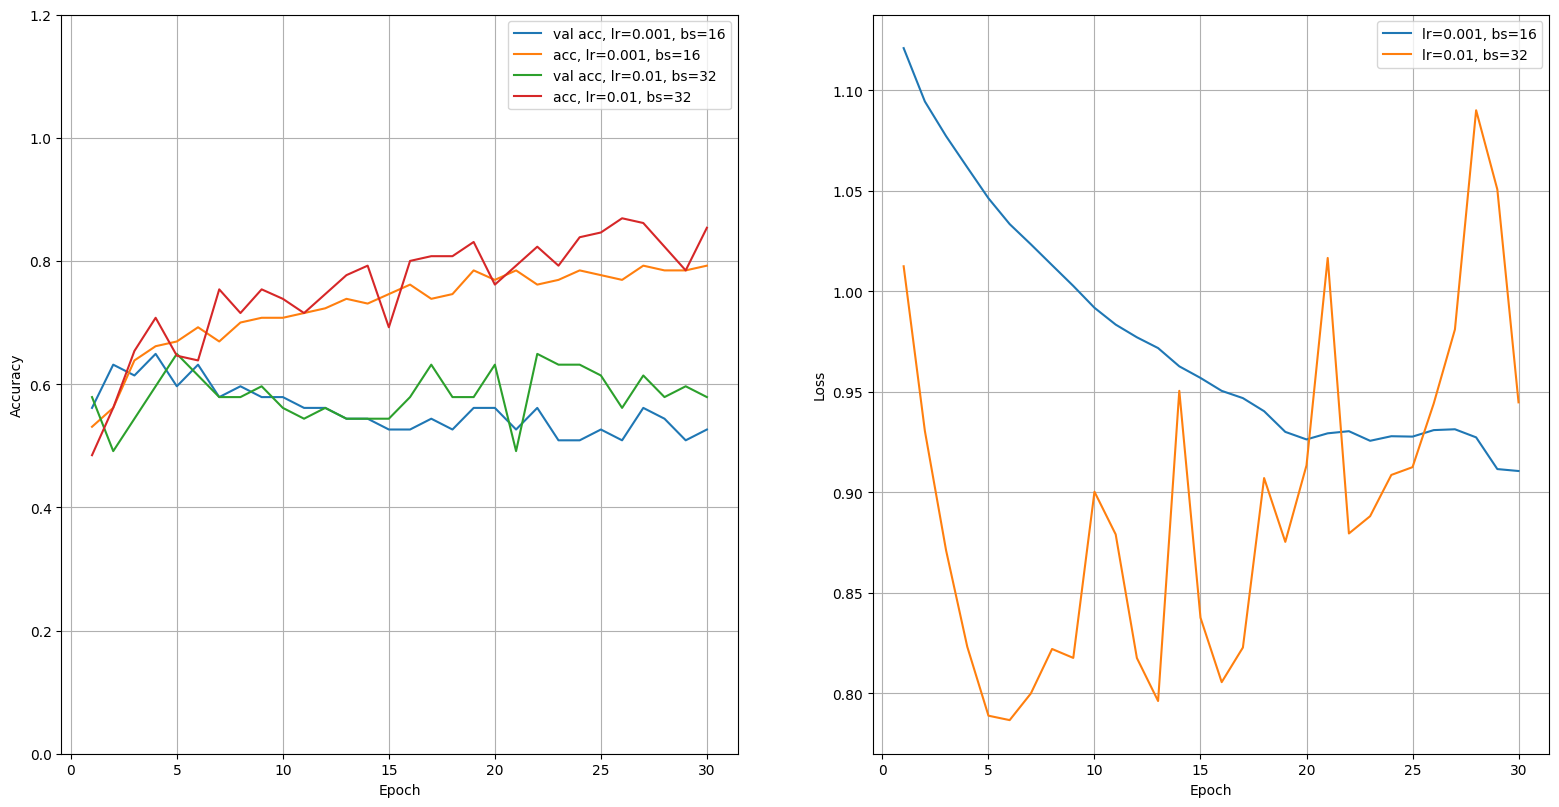

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))

history1, y_pred1, y_val1 = train_model(epochs, hidden_unit_size, lr=0.001, bs=16)
history2, y_pred2, y_val2 = train_model(epochs, hidden_unit_size, lr=0.01, bs=32)


ax[0].plot(range(1, len(history1.history['val_accuracy'])+1), history1.history['val_accuracy'], label='val acc, lr=0.001, bs=16')
ax[0].plot(range(1, len(history1.history['accuracy'])+1), history1.history['accuracy'], label='acc, lr=0.001, bs=16')

ax[0].plot(range(1, len(history2.history['val_accuracy'])+1), history2.history['val_accuracy'], label='val acc, lr=0.01, bs=32')
ax[0].plot(range(1, len(history2.history['accuracy'])+1), history2.history['accuracy'], label='acc, lr=0.01, bs=32')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0, 1.2)
ax[0].grid()
ax[0].legend()

ax[1].plot(range(1, len(history1.history['val_loss'])+1), history1.history['val_loss'], label='lr=0.001, bs=16')
ax[1].plot(range(1, len(history2.history['val_loss'])+1), history2.history['val_loss'], label='lr=0.01, bs=32')

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].grid()
ax[1].legend()

#### Konacan odabir vrednosti za leaning rate i batch size

In [53]:
lr = 0.001
bs = 16

### 3.3.2. Eksperimentisanje sa razlicito definisanim skrivenim slojevima

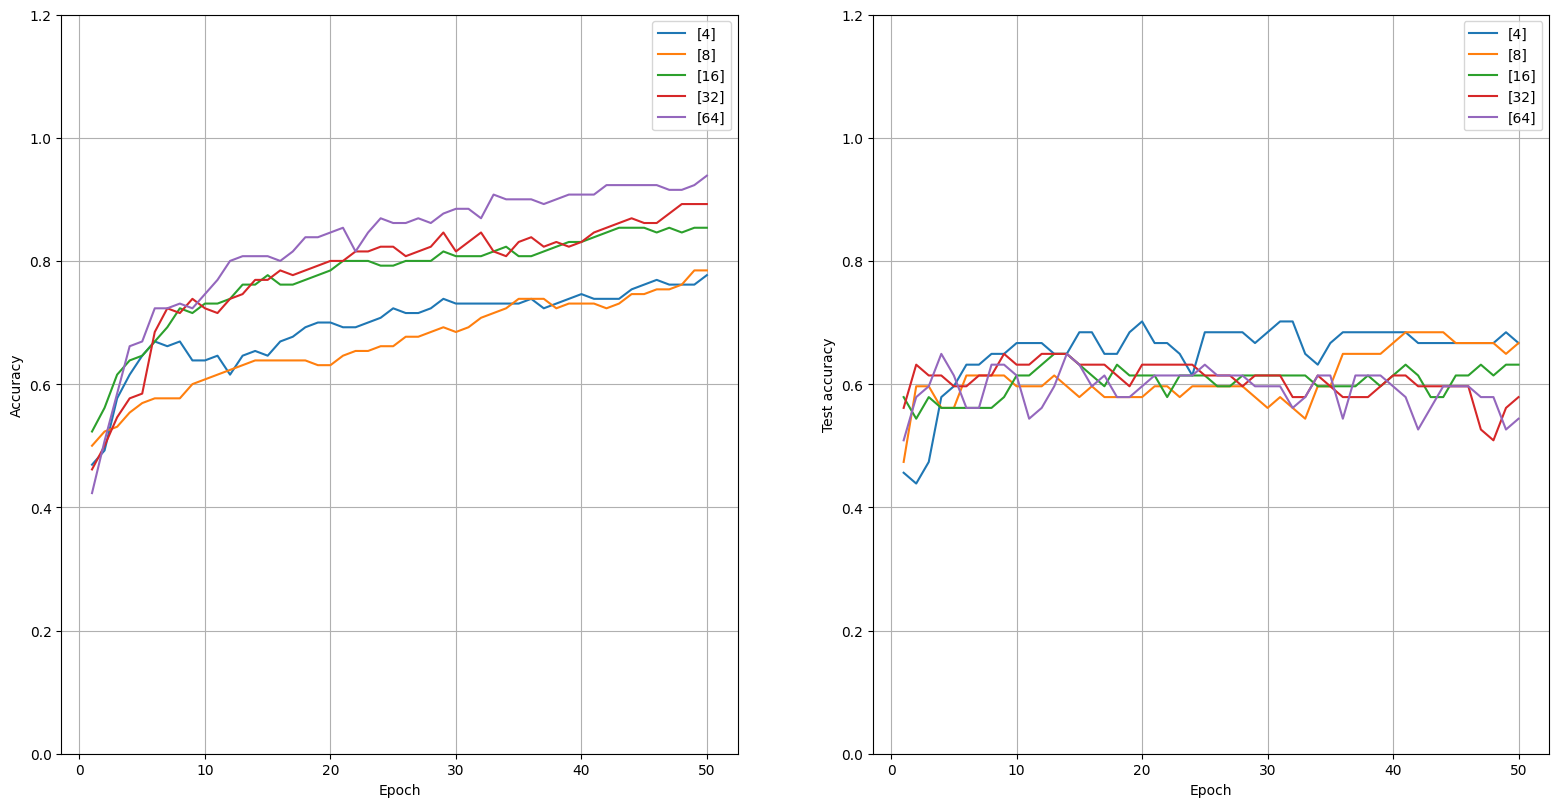

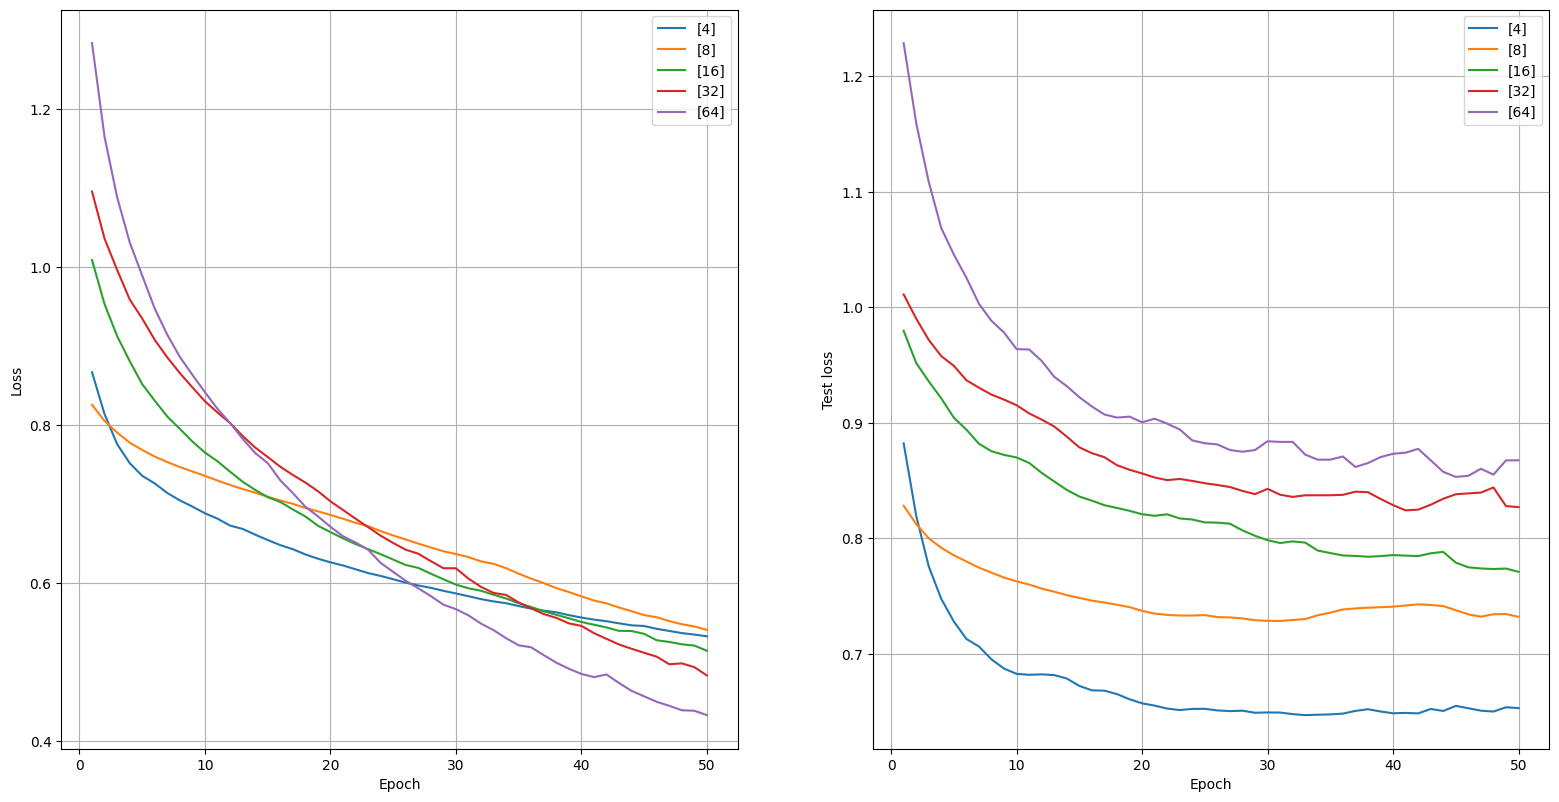

In [54]:
# Jedan skriveni sloj
hidden_unit_size = [[4], [8], [16], [32], [64]]
epochs = 50

histories = []
fig1, ax1 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))
fig2, ax2 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))

for hus in hidden_unit_size:
    history, y_pred, y_val = train_model(epochs, hus, lr=lr, bs=bs)
    
    ax1[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label=hus)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_ylim(0, 1.2)
    ax1[0].grid()
    ax1[0].legend()

    ax1[1].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=hus)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('Test accuracy')
    ax1[1].set_ylim(0, 1.2)
    ax1[1].grid()
    ax1[1].legend()

    ax2[0].plot(range(1, len(history.history['loss'])+1), history.history['loss'], label=hus)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Loss')
    ax2[0].grid()
    ax2[0].legend()

    ax2[1].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=hus)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('Test loss')
    ax2[1].grid()
    ax2[1].legend()



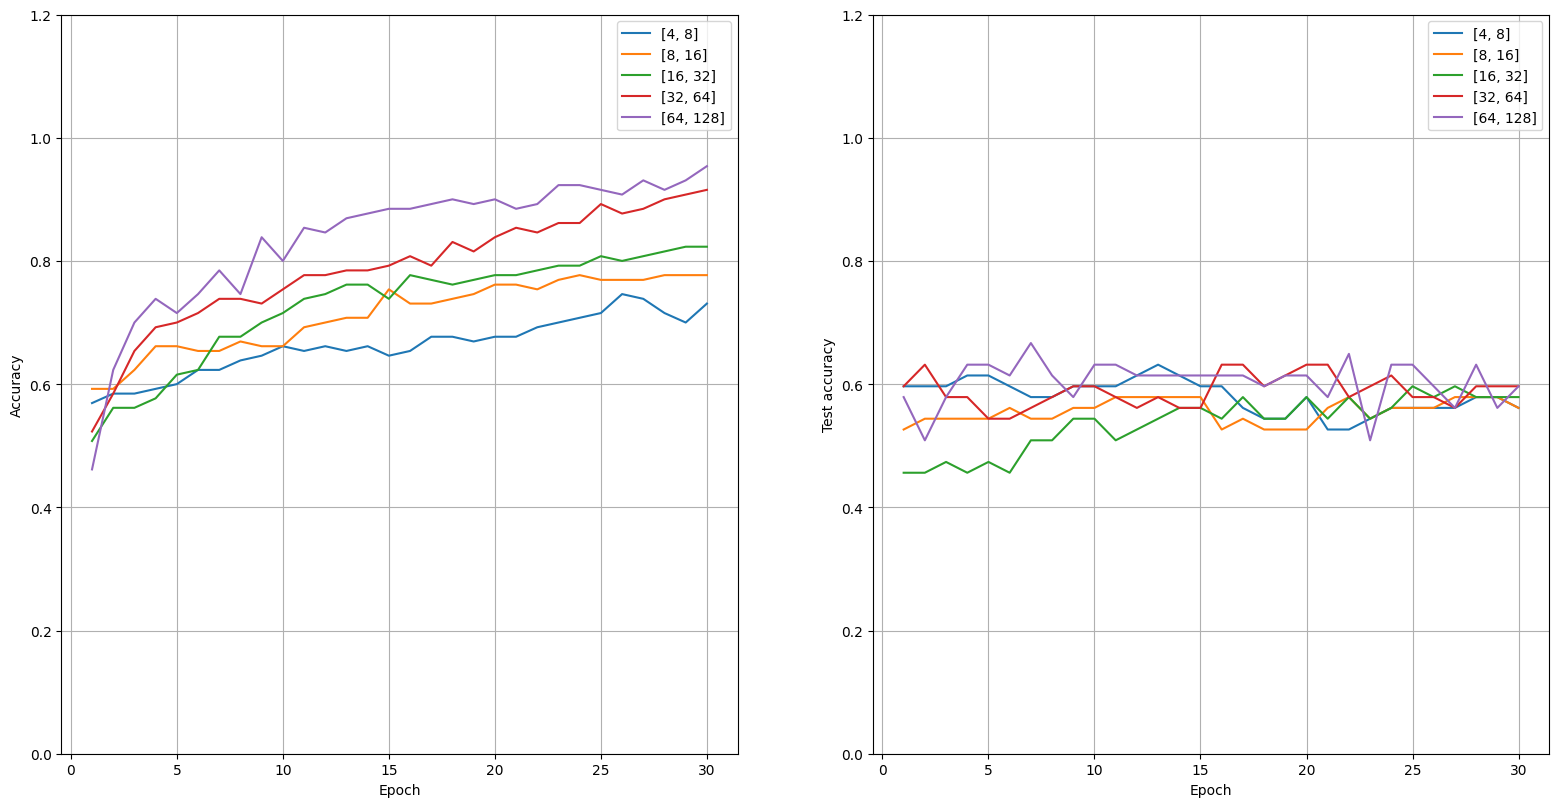

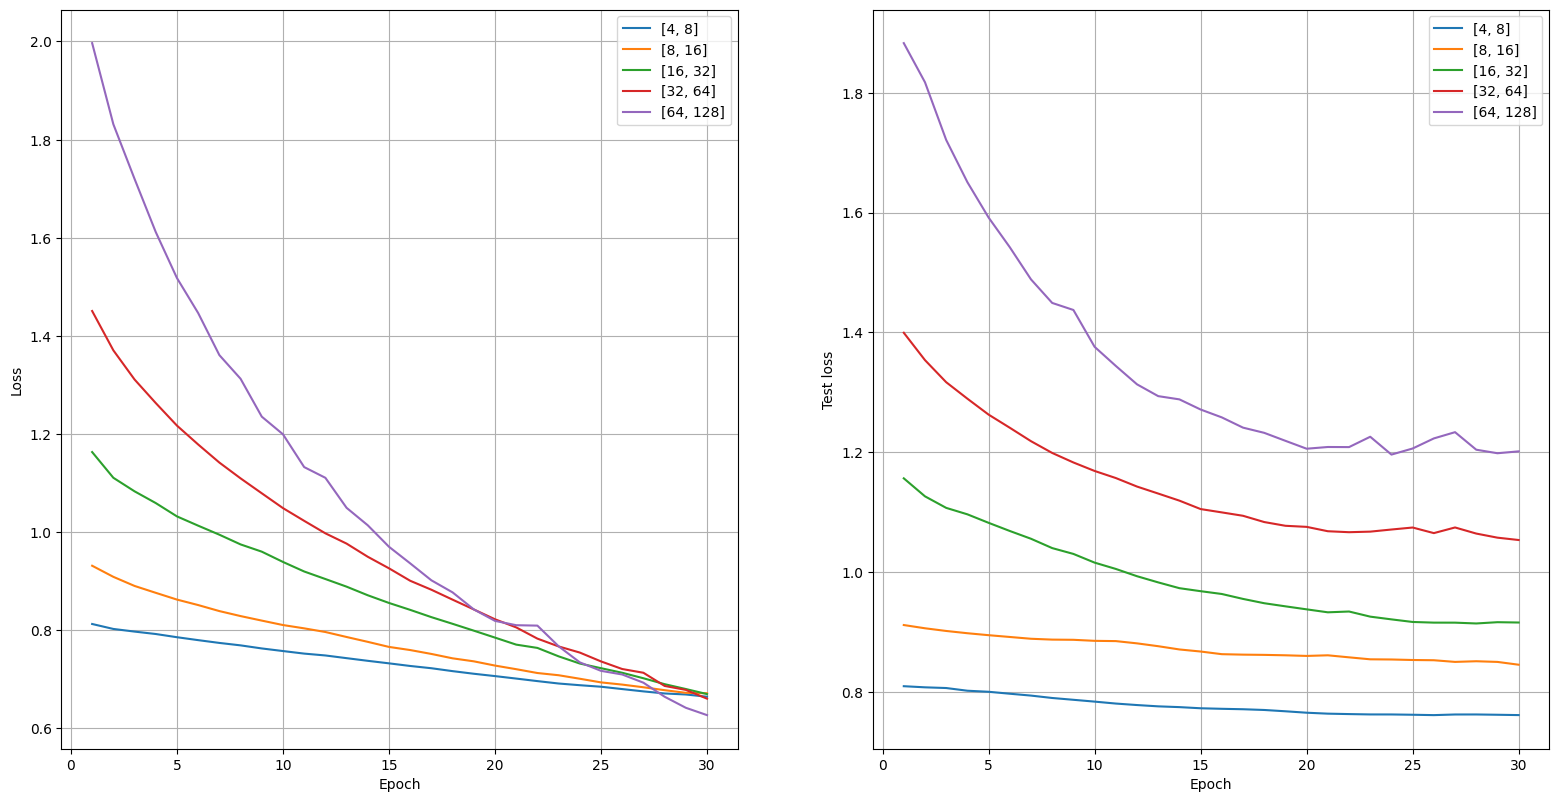

In [55]:
# Dva skrivena sloja
hidden_unit_size = [[4, 8], [8, 16], [16, 32], [32, 64], [64, 128]]
epochs = 30

histories = []
fig1, ax1 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))
fig2, ax2 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))

for hus in hidden_unit_size:
    history, y_pred, y_val = train_model(epochs, hus, lr=lr, bs=bs)
    
    ax1[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label=hus)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_ylim(0, 1.2)
    ax1[0].grid()
    ax1[0].legend()

    ax1[1].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=hus)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('Test accuracy')
    ax1[1].set_ylim(0, 1.2)
    ax1[1].grid()
    ax1[1].legend()

    ax2[0].plot(range(1, len(history.history['loss'])+1), history.history['loss'], label=hus)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Loss')
    ax2[0].grid()
    ax2[0].legend()

    ax2[1].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=hus)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('Test loss')
    ax2[1].grid()
    ax2[1].legend()

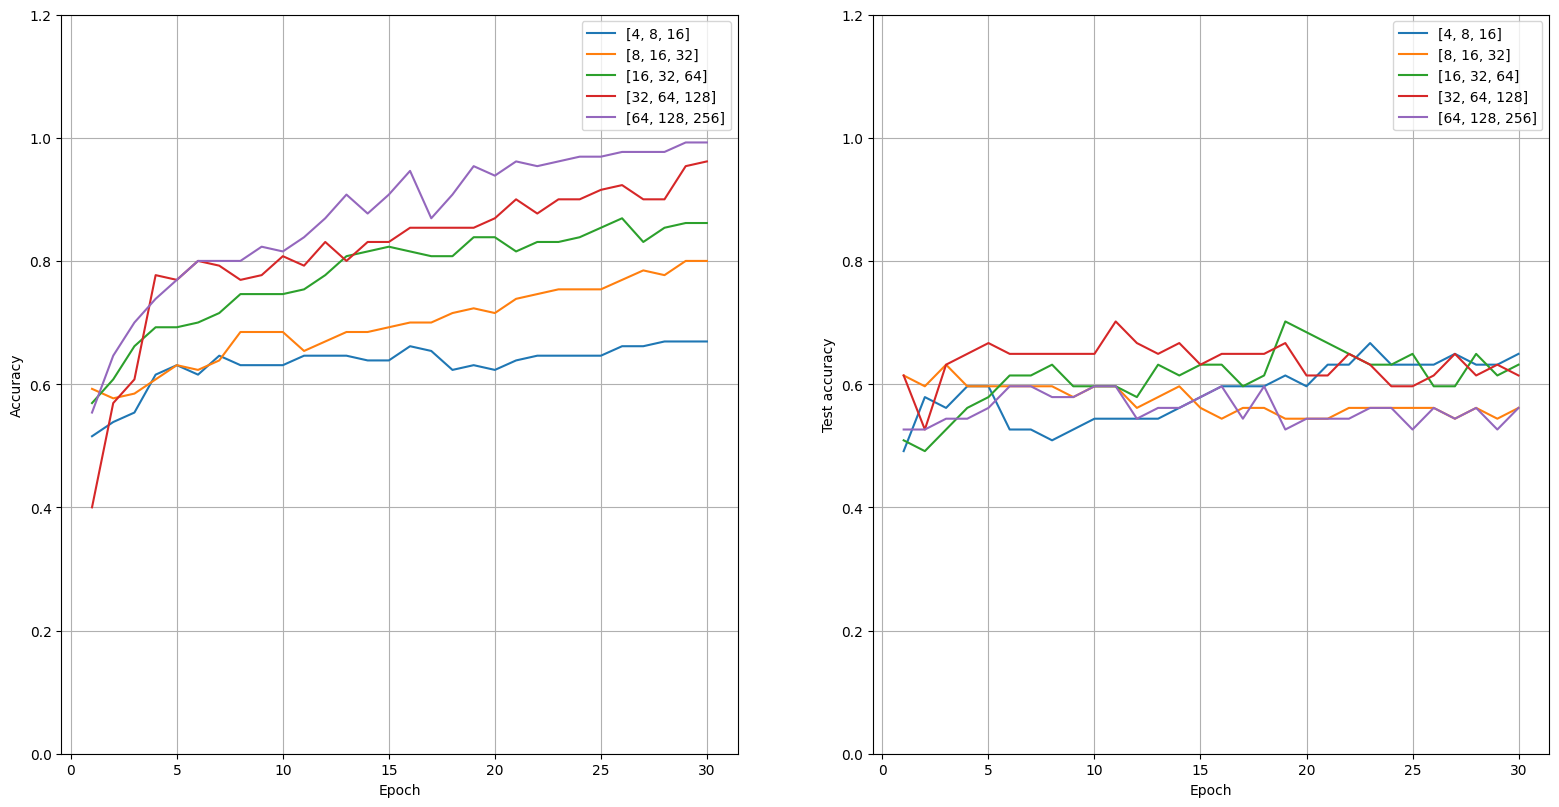

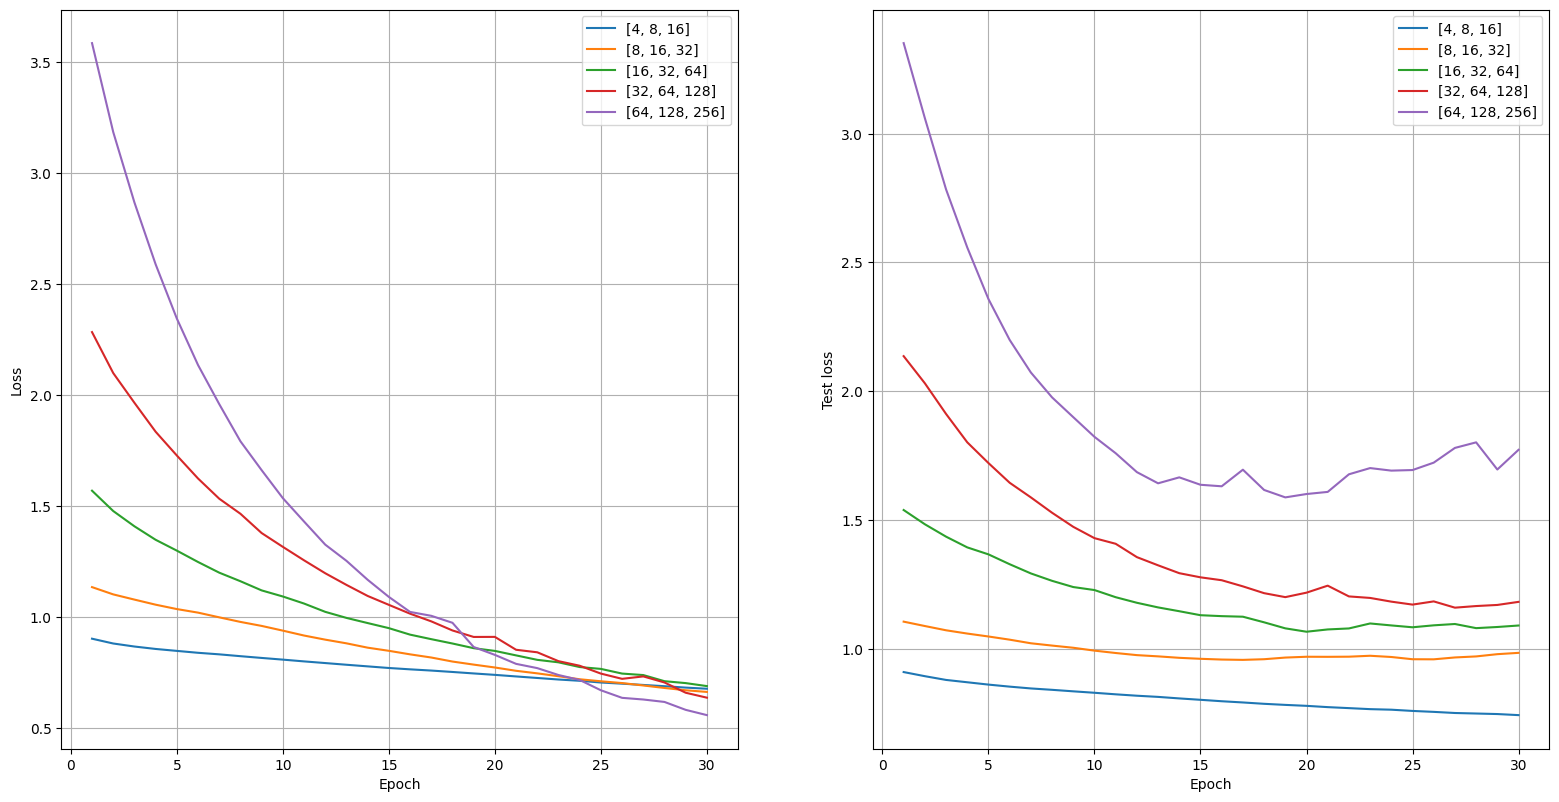

In [56]:
# Tri skrivena sloja
hidden_unit_size = [[4, 8, 16], [8, 16, 32], [16, 32, 64], [32, 64, 128], [64, 128, 256]]
epochs = 30

histories = []
fig1, ax1 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))
fig2, ax2 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))

for hus in hidden_unit_size:
    history, y_pred, y_val = train_model(epochs, hus, lr=lr, bs=bs)
    
    ax1[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label=hus)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_ylim(0, 1.2)
    ax1[0].grid()
    ax1[0].legend()

    ax1[1].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=hus)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('Test accuracy')
    ax1[1].set_ylim(0, 1.2)
    ax1[1].grid()
    ax1[1].legend()

    ax2[0].plot(range(1, len(history.history['loss'])+1), history.history['loss'], label=hus)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Loss')
    ax2[0].grid()
    ax2[0].legend()

    ax2[1].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=hus)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('Test loss')
    ax2[1].grid()
    ax2[1].legend()

### 3.3.3. Eksperimentisanje sa dodavanjem regularizacije i ranog zaustavljanja

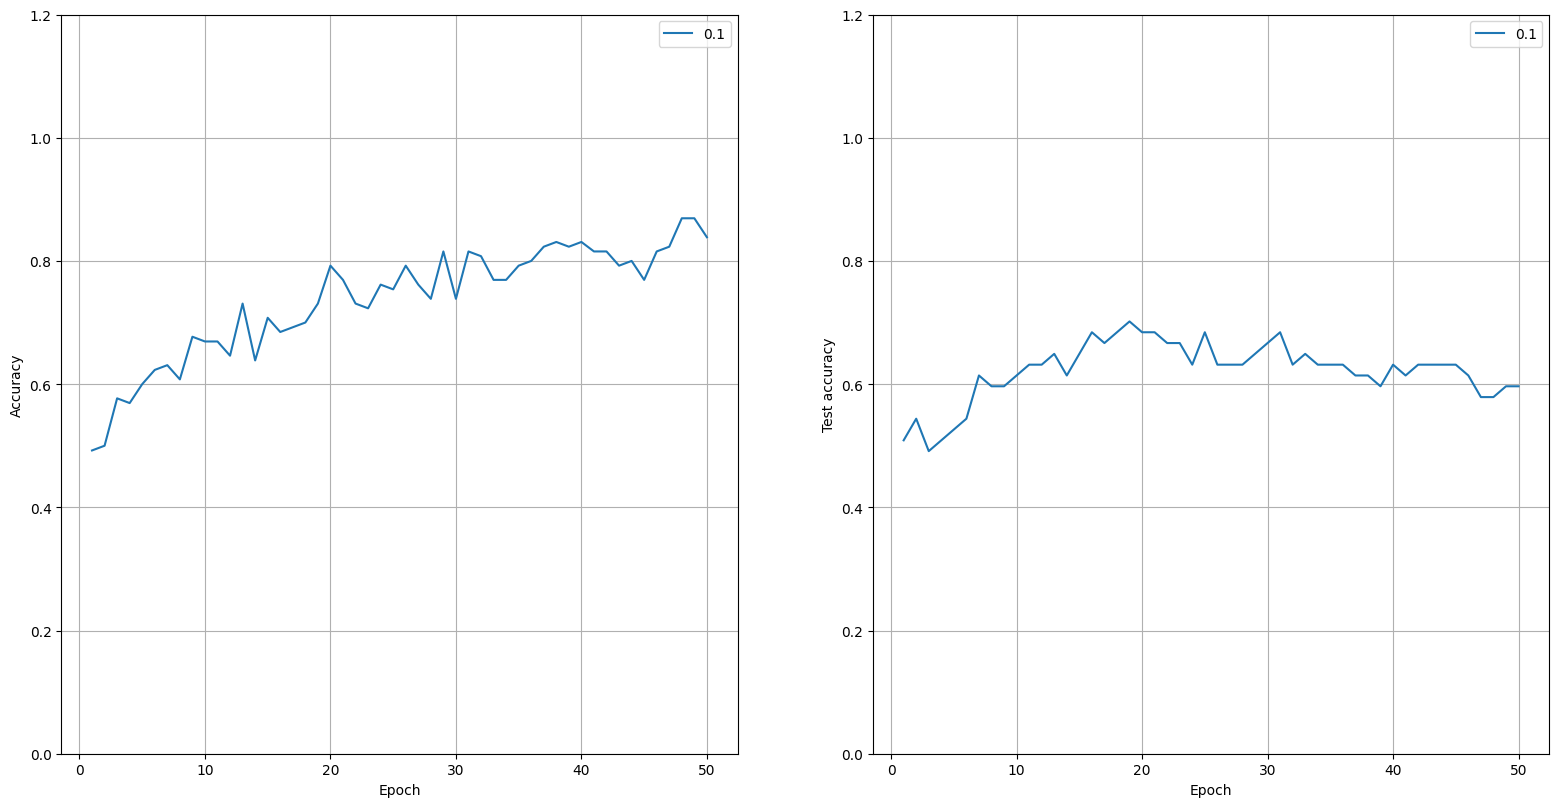

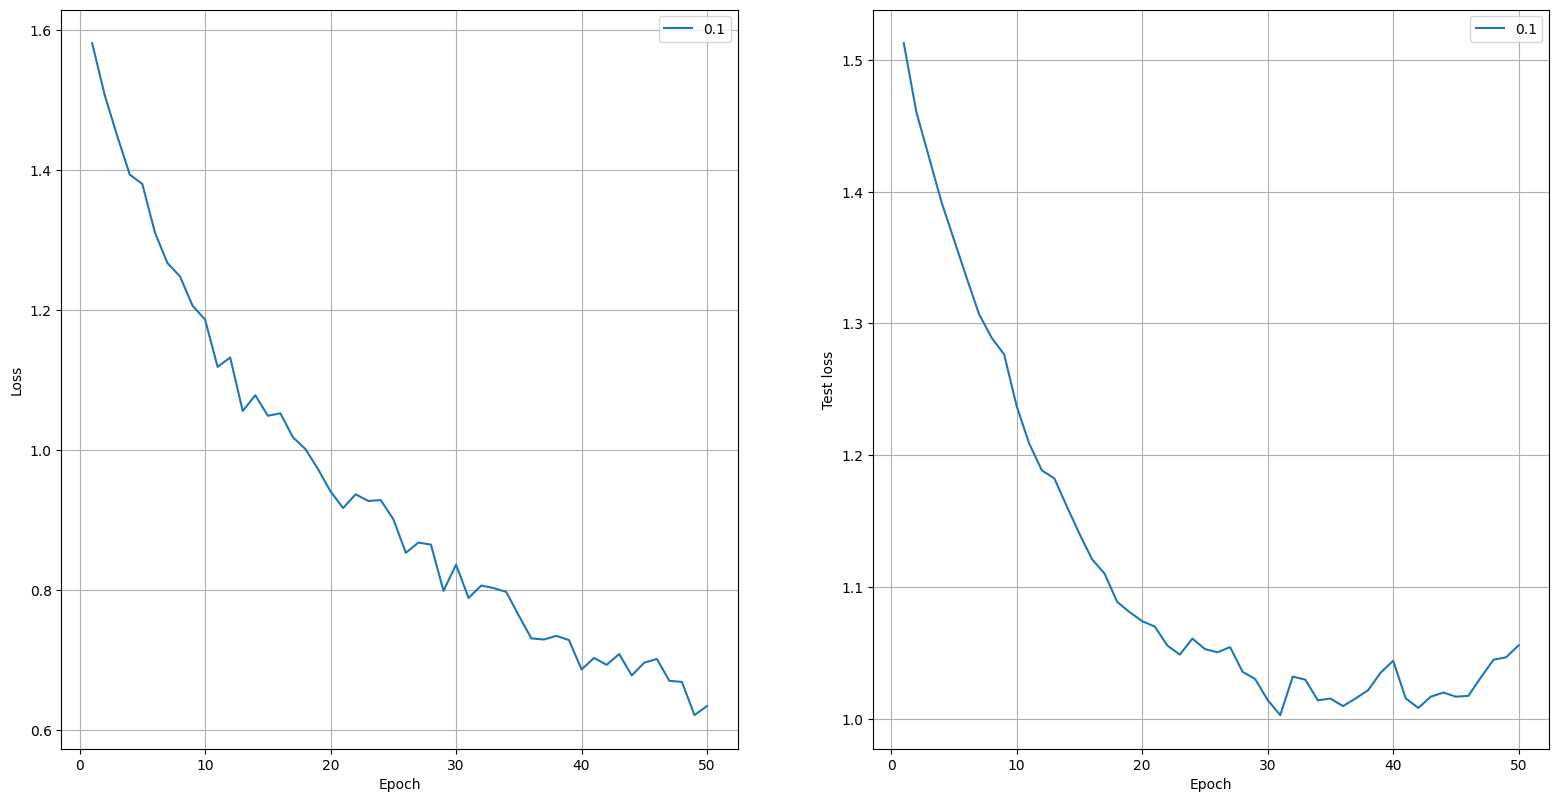

In [57]:
# Jedan skriveni sloj
dropout = [0.1]
epochs = 50

histories = []
fig1, ax1 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))
fig2, ax2 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))

for d in dropout:
    history, y_pred, y_val = train_model(epochs, [16, 32, 64], lr=lr, bs=bs, dropout=d)
    
    ax1[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label=d)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_ylim(0, 1.2)
    ax1[0].grid()
    ax1[0].legend()

    ax1[1].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=d)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('Test accuracy')
    ax1[1].set_ylim(0, 1.2)
    ax1[1].grid()
    ax1[1].legend()

    ax2[0].plot(range(1, len(history.history['loss'])+1), history.history['loss'], label=d)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Loss')
    ax2[0].grid()
    ax2[0].legend()

    ax2[1].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=d)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('Test loss')
    ax2[1].grid()
    ax2[1].legend()



### 3.3.4. Eksperimentisanje sa augmentacijom podataka

In [58]:
cols = ['Donorage numeric', 'Recipientage numeric', 'CD34kgx10d6 numeric', 'CD3dCD34 numeric', 'CD3dkgx10d8 numeric', 'Rbodymass numeric', 'ANCrecovery numeric', 'PLTrecovery numeric', 'time_to_aGvHD_III_IV numeric']

X_norm_augmented = pd.DataFrame(np.repeat(X_norm.values, 2, axis=0))
X_norm_augmented.columns = X_norm.columns

X_norm_augmented[cols] = np.random.normal(0, np.std(X_norm_augmented[cols], axis=0)) + X_norm_augmented[cols]
X_norm_augmented = pd.concat([X_norm.copy(), X_norm_augmented])

In [59]:

X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_norm_data, y, test_size=0.5, random_state=42)
X_train = np.repeat(X_train_temp, 5, axis=0)

col_idx = [X_norm.columns.get_loc(c) for c in cols if c in X_norm]
X_train[:, col_idx] = np.random.normal(0, np.std(X_train[:, col_idx], axis=0)) + X_train[:, col_idx]
X_train = np.append(X_train_temp, X_train, axis=0)

y_train = np.append(y_train_temp, np.repeat(y_train_temp, 5, axis=0))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(558, 35) (558,) (94, 35) (94,)


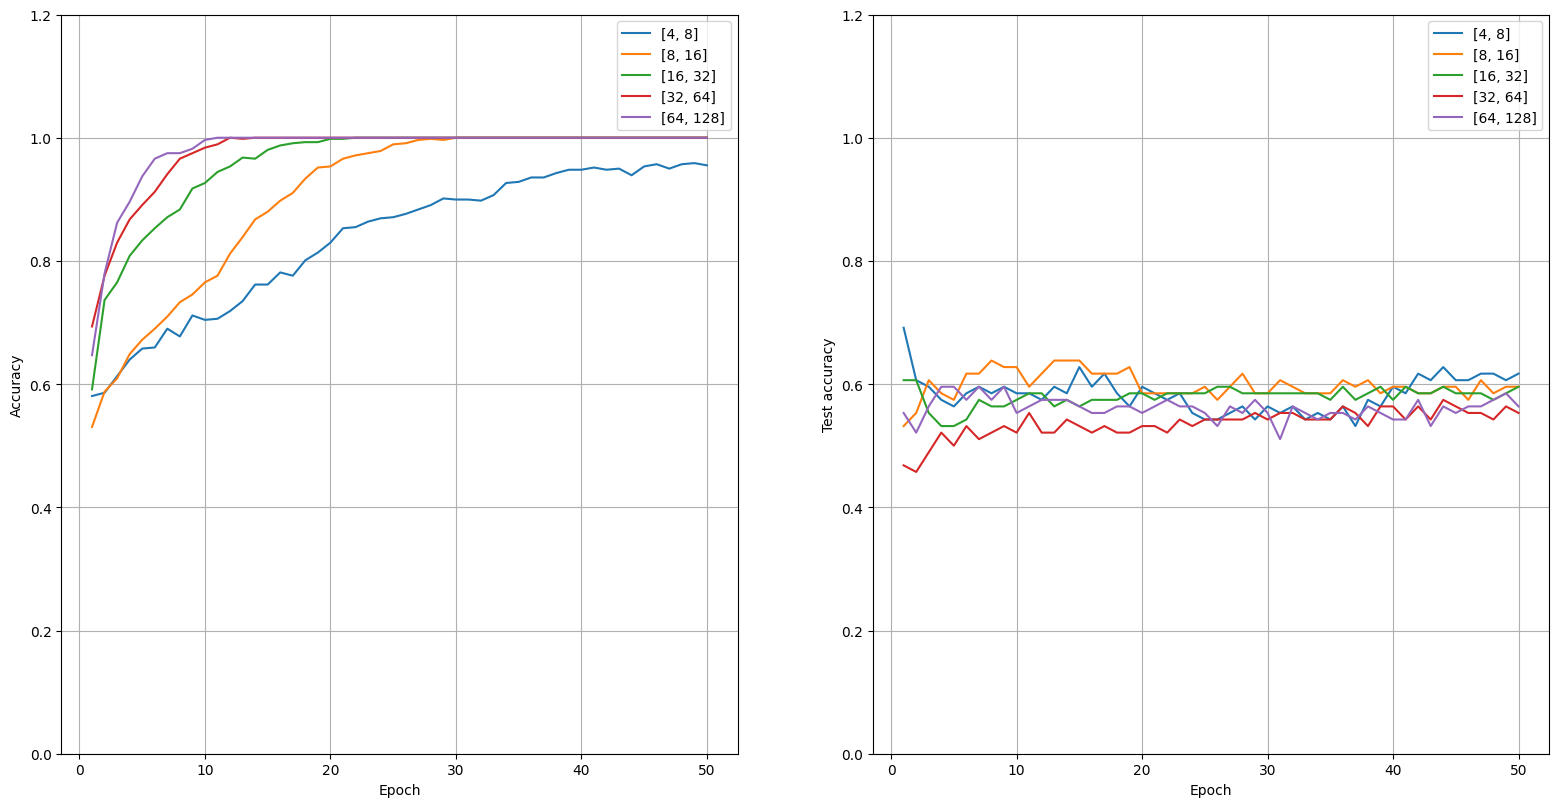

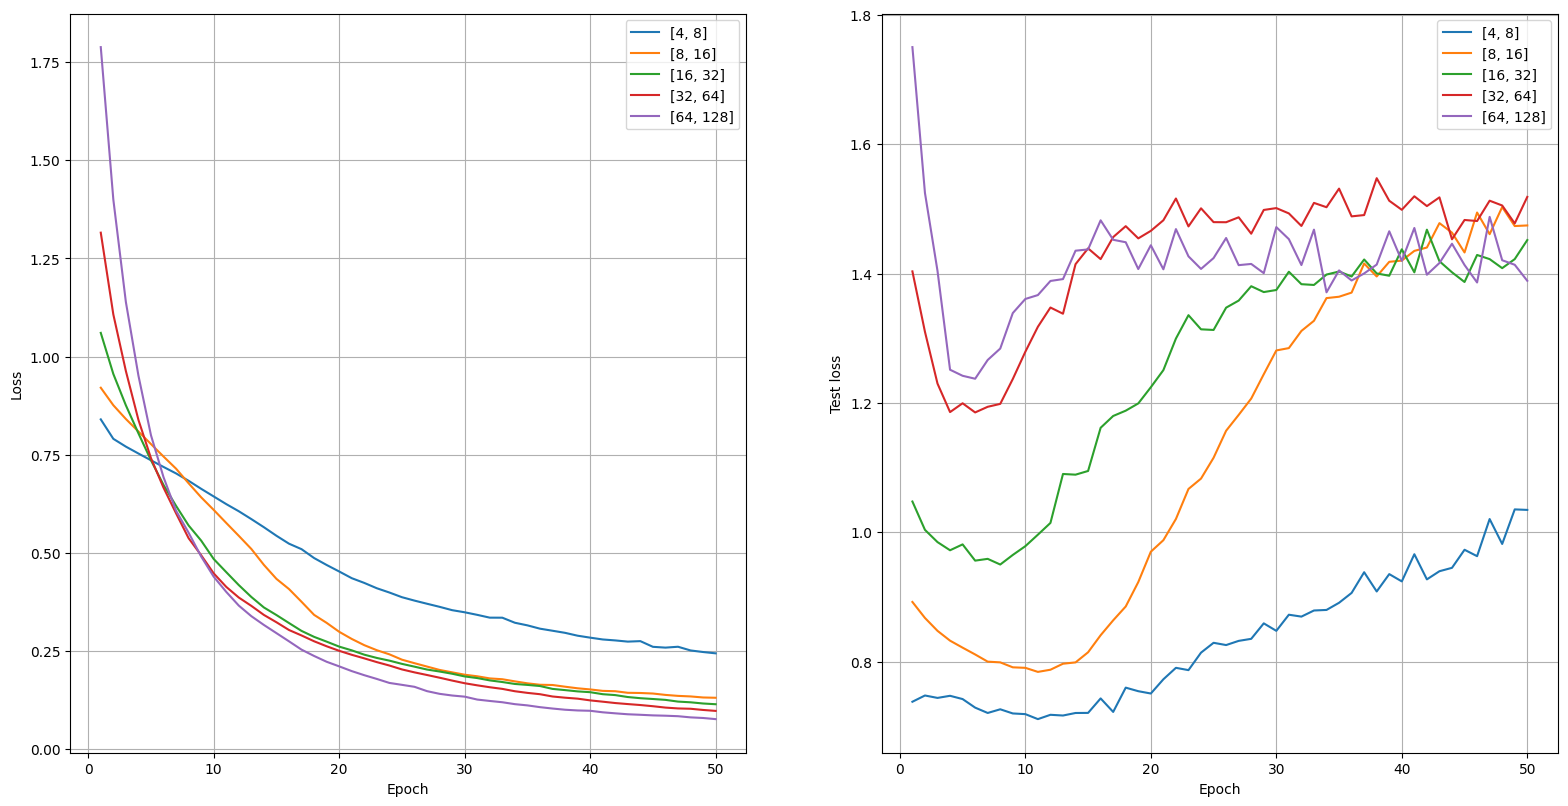

In [60]:
# Jedan skriveni sloj
hidden_unit_size = [[4, 8], [8, 16], [16, 32], [32, 64], [64, 128]]
epochs = 50

histories = []
fig1, ax1 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))
fig2, ax2 = plt.subplots(1, 2, figsize=(6.4*3, 4.8*2))

for hus in hidden_unit_size:
    history, y_pred, y_val = train_model(epochs, hus, lr=lr, bs=bs)
    
    ax1[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label=hus)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_ylim(0, 1.2)
    ax1[0].grid()
    ax1[0].legend()

    ax1[1].plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label=hus)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('Test accuracy')
    ax1[1].set_ylim(0, 1.2)
    ax1[1].grid()
    ax1[1].legend()

    ax2[0].plot(range(1, len(history.history['loss'])+1), history.history['loss'], label=hus)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Loss')
    ax2[0].grid()
    ax2[0].legend()

    ax2[1].plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label=hus)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('Test loss')
    ax2[1].grid()
    ax2[1].legend()

